In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import random
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_score
from sklearn import preprocessing

In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## 1. k-Means Clustering “By Hand”

In [3]:
## update cluster assignments
def reassign(point, cent, k):
    sim = [np.linalg.norm(np.array(point)-cent[i]) for i in cent]
    return sim.index(min(sim))

def k_means(data, k):
    ## initialization
    cluster = np.random.choice(a=range(k), size=10)
    ## update clusters
    new_clusters = np.zeros(10)
    while not np.all(new_clusters == cluster):
        ## calculate cluster centroids
        cent = {i:data[np.where(cluster==i)].mean(axis=0) for i in range(k)}
        cluster = new_clusters.copy()
        new_clusters = [reassign(p, cent, k) for p in data]
        cluster = new_clusters
    return new_clusters

In [4]:
x1 = [5,8,7,8,3,4,2,3,4,5]
x2 = [8,6,5,4,3,2,2,8,9,8]
data = np.array(list(zip(x1, x2)))

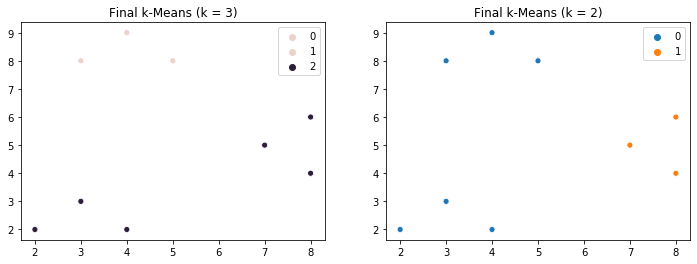

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.scatterplot(x=data[:,0], y = data[:,1], hue = k_means(data, 3), ax = axes[0])
axes[0].set_title('Final k-Means (k = 3)')

sns.scatterplot(x=data[:,0], y = data[:,1], hue = k_means(data, 2), ax = axes[1])
axes[1].set_title('Final k-Means (k = 2)')

plt.show()

* k=3 fits better than k=2 because the data is naturally scattered into three clusters. K-means tries to cluster data points into 2 clusters when k=2, which means it basically seperated the middle cluster to reach two clusters. 
* Also, when k=2, the clusters are different each time when we run the algorithm, depending on how the centers are assigned (randomly) as first.

## 2. Application

In [6]:
data = pd.read_csv('data/wiki.csv')

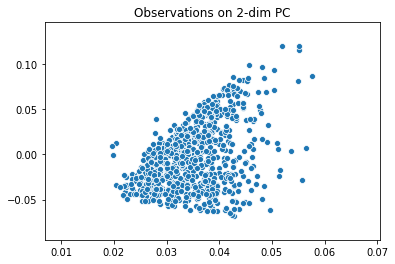

In [26]:
pca = PCA(n_components=2).fit(data.T)
sns.scatterplot(x = pca.components_[0], y = pca.components_[1])
plt.title('Observations on 2-dim PC')
plt.show()

In [27]:
import statsmodels.api as sm

for ind in data.columns:
    if len(set(data[ind])) < 10: continue ## find continous variables
    reg = sm.OLS(pca.components_[0], 
                 sm.add_constant(data[[ind]])).fit()
    if reg.pvalues[1] < 0.01: print('first', ind)
    
    reg = sm.OLS(pca.components_[1], 
                 sm.add_constant(data[[ind]])).fit()
    if reg.pvalues[1] < 0.01: print('second', ind)

first age
second age
first yearsexp
second yearsexp


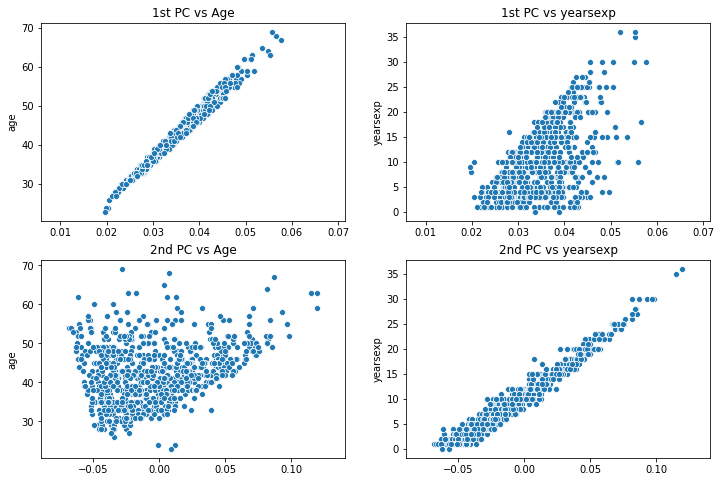

In [28]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

sns.scatterplot(x = pca.components_[0], y = data['age'], ax = axes[0, 0])
sns.scatterplot(x = pca.components_[0], y = data['yearsexp'], ax = axes[0, 1])
sns.scatterplot(x = pca.components_[1], y = data['age'], ax = axes[1, 0])
sns.scatterplot(x = pca.components_[1], y = data['yearsexp'], ax = axes[1, 1])

axes[0, 0].set_title('1st PC vs Age')
axes[0, 1].set_title('1st PC vs yearsexp')
axes[1, 0].set_title('2nd PC vs Age')
axes[1, 1].set_title('2nd PC vs yearsexp')

plt.show()

As shown above, `Age` is strongly correlated on the first principal component, and `yearsexp` is strongly correlated on the second principal component.

In [10]:
pve = pca.explained_variance_ratio_
print('First and second PVEs', pve)
print('Explained,', round(pve.sum(), 4))

pca_n = PCA(n_components=data.shape[1]).fit(data.T)
print('total PVE', round(sum(pca_n.explained_variance_ratio_), 4))

First and second PVEs [0.95648559 0.0209715 ]
Explained, 0.9775
total PVE 1.0


The first components has 95.6% PVE and the second has 2.1%. The total PVE, if we have `n_components` = `number of columns for data`, is 1. In another word, approximately 97.7% of the variance is explained by the first two principal components.

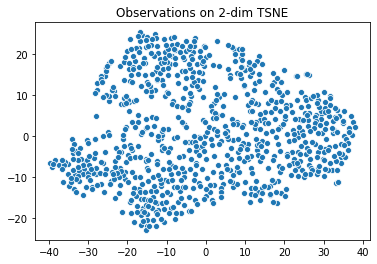

In [11]:
tsne = TSNE(n_components=2).fit_transform(data)
sns.scatterplot(x = tsne[:,0], y = tsne[:,1])
plt.title('Observations on 2-dim TSNE')
plt.show()

In [12]:
for ind in data.columns:
    if len(set(data[ind])) < 10: continue ## find continous variables
    reg = sm.OLS(tsne[:,0], 
                 sm.add_constant(data[[ind]])).fit()
    if reg.pvalues[1] < 0.01: print('first', ind)
    
    reg = sm.OLS(tsne[:,1], 
                 sm.add_constant(data[[ind]])).fit()
    if reg.pvalues[1] < 0.01: print('second', ind)

first age
second age
first yearsexp
second yearsexp


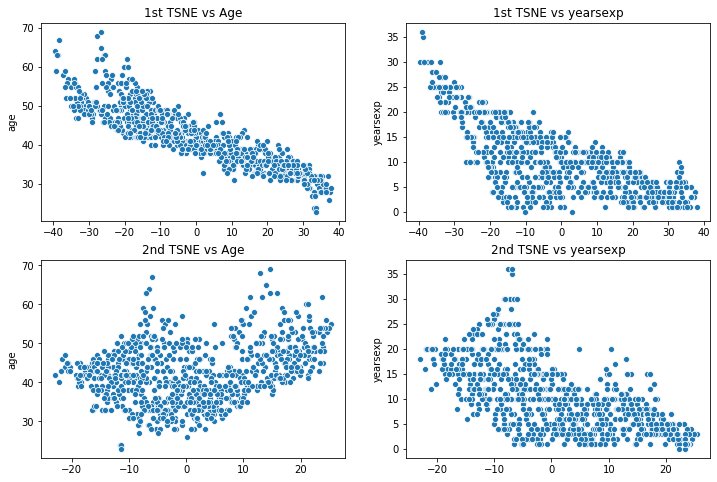

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

sns.scatterplot(x = tsne[:,0], y = data['age'], ax = axes[0, 0])
sns.scatterplot(x = tsne[:,0], y = data['yearsexp'], ax = axes[0, 1])
sns.scatterplot(x = tsne[:,1], y = data['age'], ax = axes[1, 0])
sns.scatterplot(x = tsne[:,1], y = data['yearsexp'], ax = axes[1, 1])

axes[0, 0].set_title('1st TSNE vs Age')
axes[0, 1].set_title('1st TSNE vs yearsexp')
axes[1, 0].set_title('2nd TSNE vs Age')
axes[1, 1].set_title('2nd TSNE vs yearsexp')

plt.show()

TSNE emphasizes more on minimizing the divergence between the pairwise similarities of the input objects and the pairwise similarities of the corrresponding low-dimensional points in the embedding, and thus does not assume linearity as PCA does. Therefore, although `Age` and `Yearsexp` still play an important role, the first and second TSNE dimensions do not have an strictly defined linearly relationship with these two variables. Nevertheless, `Yearsexp` still kind of has a linear relationship with the 1st TNSE and `Age` with the 2nd. But not only are these linearities looser, but also the relationship between the 2nd TNSE and `Age` is negative. 

## 3. Clustering

In [14]:
X_scaled = preprocessing.scale(data)
X_scaled = pd.DataFrame(X_scaled)
X_scaled.columns = data.columns
X_scaled.head() ## all features

In [15]:
X_scaled.head() ## all features

,age,gender,phd,yearsexp,userwiki,pu1,pu2,pu3,peu1,peu2,...,exp5,domain_Sciences,domain_Health.Sciences,domain_Engineering_Architecture,domain_Law_Politics,uoc_position_Associate,uoc_position_Assistant,uoc_position_Lecturer,uoc_position_Instructor,uoc_position_Adjunct
0,-0.287189,-0.864132,1.142574,0.531838,-0.397168,0.872008,0.881476,-0.406270,0.855337,1.170853,...,-0.408640,3.450105,-0.304789,-0.583124,-0.546536,3.280961,-0.258199,-0.151717,-0.050063,-2.161888
1,-0.022040,-0.864132,1.142574,1.124208,-0.397168,-1.121153,-0.139046,-0.406270,-0.397904,-0.026951,...,1.094403,-0.289846,-0.304789,-0.583124,1.829707,3.280961,-0.258199,-0.151717,-0.050063,-2.161888
2,-0.684911,-0.864132,1.142574,0.383745,-0.397168,-1.121153,-1.159568,-1.356608,-0.397904,-0.026951,...,0.342882,-0.289846,-0.304789,1.714901,-0.546536,-0.304789,3.872983,-0.151717,-0.050063,-2.161888
3,-0.287189,-0.864132,-0.875217,0.383745,-0.397168,-0.124573,-0.139046,0.544069,-1.651145,-1.224754,...,1.094403,-0.289846,-0.304789,1.714901,-0.546536,-0.304789,3.872983,-0.151717,-0.050063,-2.161888
4,1.171127,-0.864132,-0.875217,-0.356718,2.517826,0.872008,-0.139046,1.494407,0.855337,-0.026951,...,1.094403,-0.289846,-0.304789,1.714901,-0.546536,-0.304789,3.872983,-0.151717,-0.050063,-2.161888


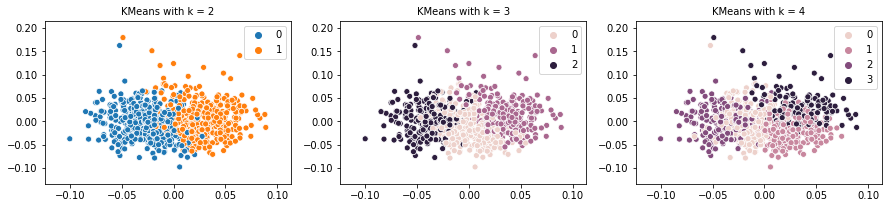

In [30]:
pca_scaled = PCA(n_components=2).fit(X_scaled.T)

def plot_kmeans(x):
    k, ax = x[0], x[1]
    label = KMeans(n_clusters=k, random_state=0).fit(X_scaled).labels_
    sns.scatterplot(x = pca_scaled.components_[0], y = pca_scaled.components_[1],
                    hue = label, ax = ax)
    ax.set_title(f'KMeans with k = {k}', fontsize=10)
    return plt

fig, axes = plt.subplots(1, 3, figsize=(15, 3))
plots = [plot_kmeans(x) for x in zip(range(2, 5), axes)]

There is no clear cut of the whole dataset, and it is clear that k-means basically clusters data points from different centers. But the shapes of the clusters are not salient, and as k increases, the representativeness of clusters decreases.

In [32]:
K = range(2,20) 

distortions, sht_score = [], [] 
for k in K: 
    kmeanModel = KMeans(n_clusters=k).fit(X_scaled) 
    dist = sum(np.min(cdist(X_scaled, kmeanModel.cluster_centers_, 
                            'euclidean'),axis=1))
    distortions.append(dist / X_scaled.shape[0]) 
    sht_score.append(silhouette_score(X_scaled, kmeanModel.labels_))

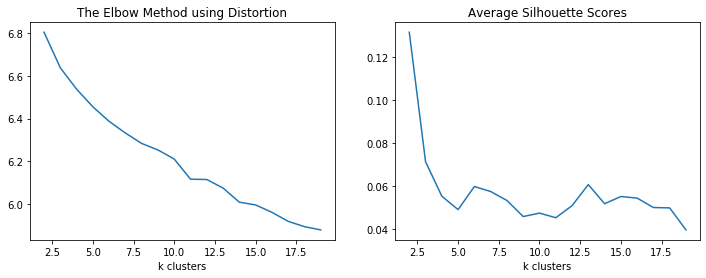

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.lineplot(x = K, y = distortions, ax = axes[0])
sns.lineplot(x = K, y = sht_score, ax = axes[1])

axes[0].set_title('The Elbow Method using Distortion')
axes[0].set_xlabel('k clusters')
axes[1].set_title('Average Silhouette Scores')
axes[1].set_xlabel('k clusters')

plt.show()

As shown in the scatterplots above, there is not a clear cluster cut among data points. Therefore, although as k increases, `distortion` monotonously decreases, there is not an "elbow" turning point. Moreover, the `average silhouette scores` dropped dramatically as k increases from k=2, suggesting that the optimal k is probably 2, if the data should be clustered at all. 

In [37]:
label = KMeans(n_clusters=2).fit(X_scaled).labels_
tsne_scaled = TSNE(n_components=2).fit_transform(X_scaled)
#pca_scaled = PCA(n_components=2).fit(X_scaled.T)

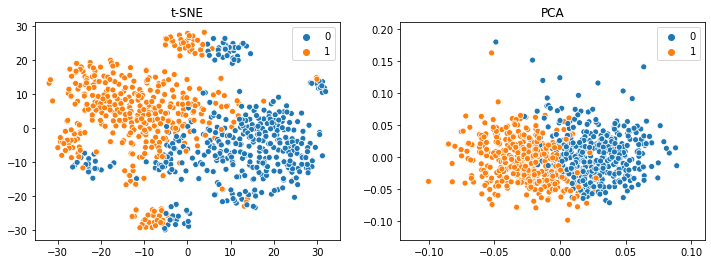

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.scatterplot(x = tsne_scaled[:,0], y = tsne_scaled[:,1], 
                hue = label, ax = axes[0])
sns.scatterplot(x = pca_scaled.components_[0], y = pca_scaled.components_[1],
                hue = label, ax = axes[1])

axes[0].set_title('t-SNE')
axes[1].set_title('PCA')

plt.show()

As k=2, it is clear that PCA better presents how k-means detects clusters--i.e. based on point distances. This is because PCA conducts a linear transformation on points and therefore does not alter the Euclidean relationship among points, which k-means relies on. On the contrary, t-SNE projects high-dimensional distributions to lower dimensions with a priority of keeping the distributional features. In another word, the transformation is non-linear and the input features are no longer identifiable. Therefore, it does not correspond to what k-means tries to capture.